<a href="https://colab.research.google.com/github/ra397/COVID19-Author-Network/blob/main/Project2HealthData_AuthorNetworkAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('metadata_April10_2020.csv')

<ipython-input-1-678d60ef403e>:4: DtypeWarning: Columns (1,4,5,6,11,12,13,14,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267

In [2]:
# Function to parse authors string into a list of individual authors
def parse_authors(authors_str):
    if pd.isna(authors_str):
        return []
    authors_list = authors_str.split(";")
    authors_list = [author.strip() for author in authors_list if author.strip() != ""]
    return authors_list

# Test function
print(parse_authors('Myatt, Theodore A; Johnston, Sebastian L; Rudnick, Stephen; Milton, Donald K'))

['Myatt, Theodore A', 'Johnston, Sebastian L', 'Rudnick, Stephen', 'Milton, Donald K']


In [3]:
# Prepare data
# Apply the parsing function to the authors column
df['parsed_authors'] = df['authors'].apply(parse_authors)

# Create a list of lists of co-authors for each publication
co_author_lists = df['parsed_authors'].tolist()

In [13]:
import networkx as nx

def create_weighted_network(list_of_lists):
    # Initialize an empty graph
    G = nx.Graph()

    # Add all unique names as nodes
    unique_names = set(name for sublist in list_of_lists for name in sublist)
    for name in unique_names:
        G.add_node(name)

    # Create a dictionary to keep track of edge weights
    edges_count = {}

    # Iterate through each list to count occurrences of each pair
    for lst in list_of_lists:
        for i in range(len(lst)):
            for j in range(i+1, len(lst)):
                edge = tuple(sorted([lst[i], lst[j]]))  # Sort to ensure consistency
                if edge in edges_count:
                    edges_count[edge] += 1
                else:
                    edges_count[edge] = 1

    # Add edges with weights to the graph
    for edge, weight in edges_count.items():
        G.add_edge(edge[0], edge[1], weight=weight)

    return G

Network = create_weighted_network(co_author_lists)

In [14]:
degrees = Network.degree()
sorted_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)
top_10_nodes = sorted_nodes[:10]
bottom_10_nodes = sorted_nodes[-10::]

for node, degree in top_10_nodes:
    print(f"Author: {node} has {degree} edges")
print('\n\n')
for node, degree in bottom_10_nodes:
    print(f"Author: {node} has {degree} edges")

Author: Li, Wei has 2289 edges
Author: Liu, Wei has 2254 edges
Author: Chen, Gang has 2128 edges
Author: Liu, Yang has 2114 edges
Author: Gao, Feng has 2090 edges
Author: Chen, Qi has 2053 edges
Author: Li, Jun has 2041 edges
Author: Huang, Yong has 2036 edges
Author: Li, Min has 2018 edges
Author: Chen, Wei has 1989 edges



Author: Yim, Bennett has 0 edges
Author: Tribe, John has 0 edges
Author: Christopher JL Murray has 0 edges
Author: Song, Yann-Huei has 0 edges
Author: Holland, R E has 0 edges
Author: Schattner, Ami has 0 edges
Author: Vora, Neil has 0 edges
Author: Coombes, Rebecca has 0 edges
Author: Schærström, A. has 0 edges
Author: Jackman, Joany has 0 edges


In [7]:
# Plot degree distribution of the network, this will help me choose the threshold for
# the minimum number of edges required for a node to be included in the visualization
import matplotlib.pyplot as plt

# Calculate the number of nodes that have at least each degree
degrees = [deg for node, deg in Network.degree()]
degrees.sort(reverse=True)
total_nodes = len(Network.nodes())
node_count_percent = [(sum(1 for deg in degrees if deg >= d) / total_nodes)
* 100 for d in range(max(degrees) + 1)]

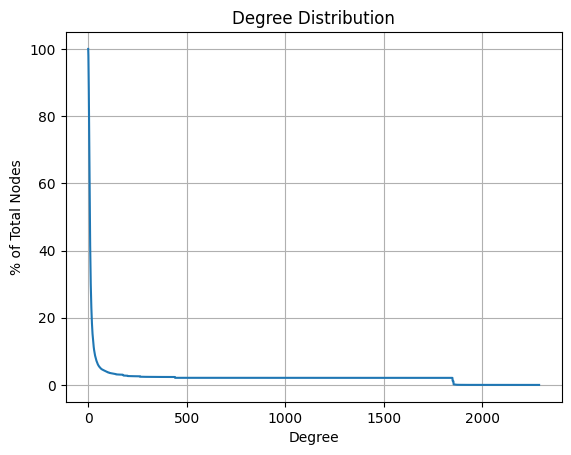

In [8]:
# Plot degree distribution curve
plt.plot(range(max(degrees) + 1), node_count_percent, linestyle='-')
plt.xlabel('Degree')
plt.ylabel('% of Total Nodes')
plt.title('Degree Distribution')
plt.grid(True)
plt.show()

- We have a classic long-tail distribution. A high percentage of nodes have a very low degree, and as the degree increases, the percentage of nodes rapidly decreases.

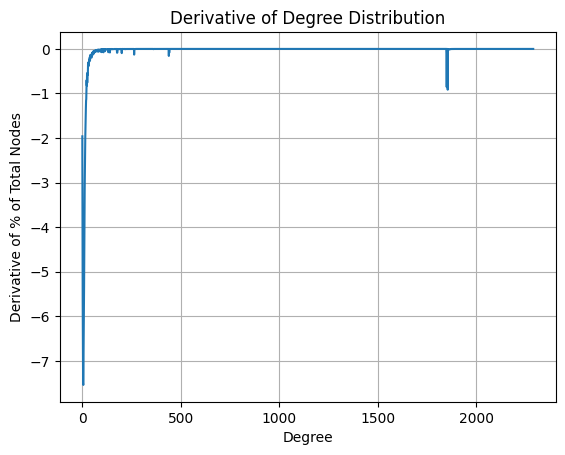

In [9]:
# Calculate the derivative of the degree distribution curve
import numpy as np

derivative = np.diff(node_count_percent)

# Plot the derivative
plt.plot(range(1, len(derivative) + 1), derivative, linestyle='-')
plt.xlabel('Degree')
plt.ylabel('Derivative of % of Total Nodes')
plt.title('Derivative of Degree Distribution')
plt.grid(True)
plt.show()

 - The derivative graph is showing the difference in percentages between one degree and the next.
 - A long vertical line means there's a significant drop in the percentage of nodes when moving from degree n to n+1
 - A short or no vertical line means there's a small or no change in the percentage of nodes between these degrees


In [15]:
degrees = dict(Network.degree())

# Calculate the frequency of each degree
degree_counts = {}
for degree in degrees.values():
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# Sort the degrees and calculate the differences between consecutive degree frequencies
sorted_degrees = sorted(degree_counts.items())
differences = [(sorted_degrees[i+1][0], sorted_degrees[i+1][1] - sorted_degrees[i][1])
               for i in range(len(sorted_degrees)-1)]

# Find the degree with the largest decrease (most negative difference)
# Since the user asked for the biggest vertical line, we assume they are looking for the biggest drop
biggest_drop_degree = min(differences, key=lambda x: x[1])[0]

biggest_drop_degree

1855

- The ```biggest_drop_degree``` is the exact degree value for the biggest vertical line in the "Derivative of Degree Distribution".
- We will use ```biggest_drop_degree``` as the threshold for the minimum number of edges required for a node to be included in the visualization

In [16]:
# Counts the number of nodes in a graph with a
def count_nodes_with_degree_at_least(graph, degree):
    count = 0
    for node in graph.nodes():
        if graph.degree(node) >= degree:
            count += 1
    return count

degree_to_count = count_nodes_with_degree_at_least(Network, biggest_drop_degree-1)
print(f'Number of nodes with degree {biggest_drop_degree-1}: {degree_to_count}')

threshold = 1855
degree_to_count = count_nodes_with_degree_at_least(Network, biggest_drop_degree)
print(f'Number of nodes with degree {biggest_drop_degree}: {degree_to_count}')

Number of nodes with degree 1854: 1910
Number of nodes with degree 1855: 297


In [18]:
# Filter the network to only include nodes that meet the degree threshold
min_degree = biggest_drop_degree
nodes_to_remove = [node for node, degree in dict(Network.degree()).items()
if degree < min_degree]
Network.remove_nodes_from(nodes_to_remove)

# Save the filtered graph so I can visualize it with Gephi
nx.write_gexf(Network, 'FilteredGraph.gexf')